# Introduction to Simulation with python

## Data Science 410

This notebook contains a hands-on introduction to simulation methods. The python language is used to illustrate each major point.

## Introduction

Simulation enables data scientists to study the behavior of stochastic processes with complex probability distributions. Simple processes might be approximated by a known, or 'named' distribution. In these simple cases, it might even be possible to derive analytical results. However, many real-world processes have complex behavior, resulting in complex distributions of output values. In these cases, simulation is a practical approach to understanding these processes. 

As cheap computational power has become ubiquitous, simulation has become a widely used technique in the data scientist's tool box. Simulations compute a large number of cases, or realizations, of the probability distribution of the process being studied. The final or posterior distribution of the process being simulated is comprised of these realizations. The computing cost of each realization must be low in any practical simulation. 

Data scientists use simulation for a number of purposes:

- Simulation is used to test models. If data simulated from the model do not resemble the original data, something is likely wrong with the model.
- Simulation is used to understand processes with complex probability distributions. In these cases, simulation provides a powerful and flexible computational technique to understand behavior.  

In this notebook you will create a simulation of a process with a complex distribution. 







## Creating simulations

Creating, testing and debugging simulation software can be tricky. Some of the techniques which can make your life easier are the same as you should use when developing any analytics software, or even software in general. But, given the stochastic nature of simulation, testing and debugging can be more difficult than other types of software. Some commonly employed techniques include:

- Build your simulation as a series of small, easily tested chunks In practice, this means you will build your simulation by creating and testing a set of small functions that comprise the overall model.
- Test each small functional unit individually. These tests should include at least testing some typical cases, as well as boundary or extreme cases. Sensible behavior with extreme or limiting cases is a requirement for a stable simulation. Both tabular and graphical output can be useful for evaluating these tests.
- Test your overall simulation each time you add a new functional component. This processes ensures that all the components work together. 
- Simulations are inherently stochastic. If you want to create identical numerical results, say for automated testing, set a seed before you begin tests. In this notebook no seed is set so you can experience the stochastic nature of the simulation. 

## The Scenario

The notebook implements a simulation of the profitability of a sandwich shop. Not surprisingly, the sandwich shop earns money every time a customer buys a sandwich. However, the inputs to the sandwich cost money. The daily profit is the amount customers pay for the sandwiches minus the costs of the inputs. 

The cost of bread is an input which is particularly difficult to manage. The shop bakes its own bread before the shop opens, and the bread must be used on the day it is made. The customers can select one of three types of bread, white, wheat, and multigrain. The customers are unusually picky. If the shop does not have bread of the customer's choice on hand, the customer will leave the shop without buying a sandwich. However, any extra bread left at the end of the day is discarded and the cost reduces the profitability of the shop. 

To keep the simulation simple, several assumptions are made:

- The probability that each customer chooses a particular type of bread is stationary and known. These probabilities are 50% for white bread, 25% for wheat and 25% for multigrain. 
- If a customer's choice of bread is not available the customer leaves the shop without buying a sandwich.
- The only perishable input which must be discarded at the end of each day is the bread. 
- Customers do not stop coming to the sandwich shop as a result of not finding their bread choice. 

In reality these are questionable assumptions, and a real-world situation would be more complex. The simulation techniques we are about to use can be applied to much more complex situations. 



### Representation as Directed Acyclic Graphical Model

When creating a simulation with multiple variables, some conditionally dependent it is most useful to draw a directed graph of the dependencies of the variables. Such a representation is known as an **directed acyclic graphical model or DAG** The graph shows which variables are independent and which are conditionally dependent on others. In such a graph, the probability distributions of the variables are shown as ellipses. **Decision variables** are deterministic and are shown as rectangles. The **utility** node, profit in this case, is shown as a diamond.

The directed graph for this simulation is shown in the figure below.  

<img src="img/Simulation_Directed_Graph.jpg" alt="Drawing" style="width:600px; height:300px"/>
<center>Directed graph of the distributions for profit simulation</center>

For this simulation, the arrival rate and bread choices are independent probability distributions. The probability distribution of demand for bread is dependent on arrival rate and bread choice. The profit is computed from the demand for bread and the amount of bread baked.   

## Realizations of Distribution

The ability to compute large numbers of realizations from probability distributions is fundamental to simulation. Two questions naturally arise. 

- Which distribution to choose? The answer to this question is typically determined through a combination of domain knowledge and significant data exploration. Usually, several choices are tested and compared.
- Are the distributions of the variables conditionally dependent? That is, do we need to know the distribution of some **parent variable** before we can compute the distribution of a **child variable**. 
- How many realizations are required? The answer will depend on the accuracy you require from your simulation and how patient you are. Typically, some tests will indicate an appropriate number of realizations.

Execute the code in the cell below to load the required packages. 

In [1]:
import numpy
import pandas
import scipy
import scipy.stats
from matplotlib import pyplot
import seaborn

# Configure default plot style.
seaborn.set_palette('muted')
seaborn.set_style('ticks')
%matplotlib inline

### Poisson Distribution for Arrival Rates

For arrival processes, Poisson distributions are typically used. The Poisson distribution has a single parameter, the arrival rate or intensity, $\lambda$, per time period. Given this parameter, the probability of a given number of arrivals can be computed as:

$$P(k\ arrivals\ | \lambda\ average\ arrival\ rate) = \frac{\lambda^k\ e^{-\lambda}}{k!}$$

However, if the arrival rate is fairly high, the difference between a Poisson distribution and an appropriate Normal distribution will be minimal.The code in the cell below displays histograms of a Poisson distribution with arrival rates of {1, 5, 25, 100}. Execute the code and examine the results. 

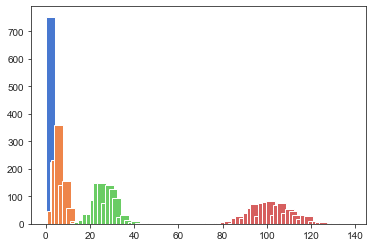

In [2]:
lambdas = [1, 5, 25, 100]
poisson_samples = [numpy.random.poisson(l, 1000) for l in lambdas]
_ = pyplot.hist(poisson_samples, bins=80, width=4)

Notice that as the expected arrival rate increases, the histogram starts to look more like that of a Normal distribution. 

Let's look at the difference between modeling the customer arrivals as a Poisson distribution versus a Normal distribution. The code in the cell below displays histograms to compare the Possion and Normal distribution for an average arrival rate of 100. Execute the code and compare the histograms.     

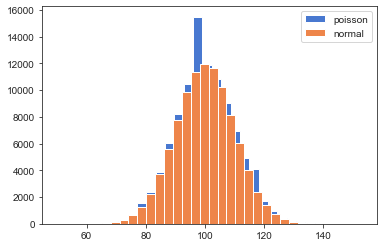

In [3]:
mu = 100
sigma = 10.0

num_samples = 100000
norm_samples = numpy.random.normal(loc=mu, scale=sigma, size=num_samples)
poisson_samples = numpy.random.poisson(lam=mu, size=num_samples)
pyplot.hist(poisson_samples, bins=30, label='poisson')
pyplot.hist(norm_samples, bins=30, label='normal')
_ = pyplot.legend()

**Your turn:** In the cells below, compute and display histograms comparing 10000 realizations of Normal and Poisson distributions with expected arrival rate of 10, 25 ad 50. You will need to find values of the standard deviation for the Normal distribution by experimenting a bit. 

## Simulate Demand

In order to develop an overall profitability model, demand must be simulated. To simulate demand you must first simulate the number of arrivals and then the demand for each type of bread given the arrivals. 

The demand for bread on a given day is simulated with the code in the cell below. Given the number of arrivals `n`, the `sim.bread` function computes the numbers of each type of bread required. The last line of code in the the cell tests the function for a single realization of 100 arrivals. Run this code and examine the result.

In [24]:
bread_probas = [
      .50,  # white
      .25,  # wheat
      .25,  # multigrain
  ]
def sim_bread(num_samples, bread_probas):
  return list(zip(
      ['white', 'wheat', 'multigrain'], 
      numpy.random.multinomial(num_samples, bread_probas)))
  
sim_bread(100, bread_probas)

[('white', 56), ('wheat', 19), ('multigrain', 25)]

Examine the table of demand by type of bread. Notice that the proportions of white, wheat and muligrain are approximately 2, 1, 1, respectively. You can now compute the bread demand for one realization of arrivals.  

Next, you must simulate realizations of the arrivals of people at the sandwich shop. 

The demand for bread is **conditionally dependent** on the number of arrivals, and the probability that customers choose each type of bread. In other words, what you need to compute is the conditional probability distribution of bread demand given arrivals, or $P(bread\ type\ |\ arrivals, probability\ of\ bread\ choice)$.

The code in the cell below performs the following operations:

- The distribution of the arrivals is computed from realizations of a Poisson distribution.
- A array is created to hold  the demand for each bread type for each realization of the arrivals.
- Loop over the realizations of the arrivals, compute the demand for each bread type, and save the results in a row of the matrix.

Execute this code and  examine the results.

In [5]:
def sim_demand(lam, num_samples, bread_probas):
  # Compute realizations of arrivals
  arrivals = numpy.random.poisson(lam=lam, size=num_samples)
  # Initalize a matrix
  demand_matrix = numpy.zeros((num_samples, 3), dtype=int)
  
  for i, a in enumerate(arrivals):
    breads, counts = zip(*sim_bread(a, bread_probas))
    # Add one realization to matrix
    demand_matrix[i] = counts
  demand = pandas.DataFrame(demand_matrix, columns=breads)
  
  return demand

sim_demand(100, 10, bread_probas)

,white,wheat,multigrain
0,49,24,21
1,53,20,22
2,54,31,22
3,46,28,24
4,47,23,32
5,62,23,19
6,51,26,25
7,49,18,29
8,37,19,25
9,70,17,26


**Your Turn:** Plot the distribution of at least one bread type based on 10000 realizations.

## Simulate Bread Baked

The number of each type of bread baked in the sandwich shop is deterministic. Presumably the shop manager has a plan for the day, and the bread is baked in advance of the customer arrivals. The code in the cell below computes a data frame containing the number of loaves of each type of bead baked. Run this code to test the function.

In [6]:
def baked_bread(n):
  baked = (['white'] * (n//2)) + (['wheat'] * (n//4)) + (['multigrain'] * (n//4))
  bread_available = dict(pandas.Series(baked).value_counts())
  return pandas.DataFrame({k:[v] for k,v in bread_available.items()})

baked_bread(100)

,white,multigrain,wheat
0,50,25,25


## Simulate and plot profit

You now have almost all the pieces in place to create the complete simulation of the distribution of profitability of the sandwich shop. The only missing piece is to compute the total profit based on the number of sandwiches sold and the cost of the bread baked. 

The calculation of the profit is done by bread type. If the demand for a bread type is less that the available bread, the cost of the bread is subtracted by the profit at that demand. If the demand is greater than the available bread, the profit is limited by the amount of bread available. 

The code in cell below performs the following operations:

- Compute the amount of bread baked.
- Compute the realizations of demand by bread type.
- For each realization of each bread type, compute the profit based on the available bread.

Run this code and examine the results.

In [7]:
baked = 100
n = 10
lamb = 100
earned = 1.0
cost = .25

def baked_bread_samples(n_samples, n_bread):
    """Sample breads baked each day."""
    return pandas.concat([
            baked_bread(n_bread) for i in range(n_samples)]
                        ).reset_index(drop=True)

bread_samples = baked_bread_samples(n, baked)
demand_samples = sim_demand(lamb, n, bread_probas)

demand_samples

,white,wheat,multigrain
0,40,17,25
1,58,30,33
2,50,18,22
3,41,25,15
4,45,27,20
5,57,26,25
6,44,35,25
7,45,24,25
8,48,27,16
9,54,21,22


In [8]:
def sim_profit(n_baked, n, lam, earned, cost, bread_probas):
    # Draw samples for bread baking supply each day.
    bread_samples = baked_bread_samples(n, n_baked)
    # Draw samples for demand each day., bread_probas
    demand_samples = sim_demand(lam, n, bread_probas)    
    # Combine the supply and demand into a single dataframe.
    supply_demand = pandas.merge(
        bread_samples, 
        demand_samples, 
        left_index=True, 
        right_index=True,
        how='inner',
        suffixes=('_supply', '_demand'))
    
    # Define how we'll get profit for a single day
    def get_profit(day):
        profit = 0
        breads = 'multigrain', 'wheat', 'white'
        for b in breads:
            supply = day['%s_supply' % b]
            demand = day['%s_demand' % b]
            # Determine how much of our bread supply was sold vs wasted.
            leftover = supply - demand
            if leftover >= 0: # If yes, compute profit
                profit += earned * demand - cost * supply
            else: # If no, limited by available bread
                profit += (earned - cost) * supply
        return profit
    
    #  Compute the profit for each data and store result in a new column.
    supply_demand['profit'] = supply_demand.apply(get_profit, axis=1)
    
    return supply_demand
    
profits = sim_profit(100, 10, 100, 1.00, .25, bread_probas)
profits

,white_supply,multigrain_supply,wheat_supply,white_demand,wheat_demand,multigrain_demand,profit
0,50,25,25,41,28,20,61.0
1,50,25,25,47,27,22,69.0
2,50,25,25,49,24,25,73.0
3,50,25,25,48,22,32,70.0
4,50,25,25,64,21,26,71.0
5,50,25,25,44,28,31,69.0
6,50,25,25,46,42,29,71.0
7,50,25,25,62,33,23,73.0
8,50,25,25,51,31,29,75.0
9,50,25,25,43,26,23,66.0


For a large number of realizations, it is easier to study the resulting distribution using summary statistics and plots. Run the code in the cell below to simulate a large number of trials that we'll plot further below

In [9]:
profits = sim_profit(100, 10000, 100, 1.00, .25, bread_probas)

Let's compute the total demand across all bread types for each day as well

In [10]:
def total_demand(day):
    return sum(day[c] for c in day.keys() if 'demand' in c)

profits['total_demand'] = profits.apply(total_demand, axis=1)
profits.head()

,white_supply,multigrain_supply,wheat_supply,white_demand,wheat_demand,multigrain_demand,profit,total_demand
0,50,25,25,54,21,28,71.0,103.0
1,50,25,25,38,27,25,63.0,90.0
2,50,25,25,38,23,38,61.0,99.0
3,50,25,25,48,26,20,68.0,94.0
4,50,25,25,48,25,25,73.0,98.0


We can now see the distribution of demand over the days of our simulation

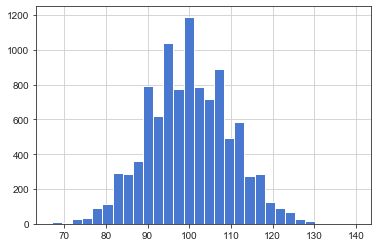

In [11]:
profits.total_demand.hist(bins=30)

and also the distribution of daily profits during the course of the simulation

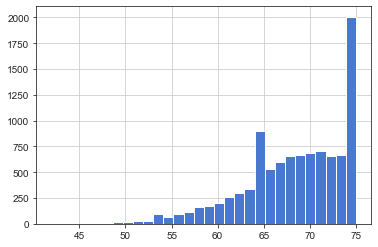

In [12]:
profits.profit.hist(bins=30)

Let's wrap up our plotting code in a function so that we can reuse it for different scenarios we'd like to simulate.

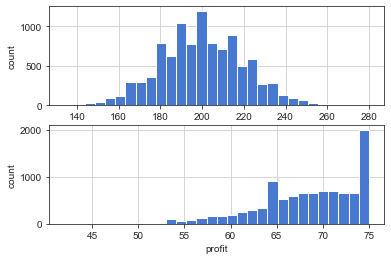

In [13]:
def plot_scenario(profits):
    profits['total_demand'] = profits.apply(total_demand, axis=1)
    
    pyplot.subplot(2, 1, 1)
    profits.total_demand.hist(bins=30)
    pyplot.xlabel('total demand')
    pyplot.ylabel('count')

    pyplot.subplot(2, 1, 2)
    profits.profit.hist(bins=30)
    pyplot.xlabel('profit')
    pyplot.ylabel('count')

plot_scenario(profits)

**Your turn:** In the cell below, create and execute the code to examine the chart of profit for  the cases where 120, 140, and 160 loaves of bread have been baked. 

## Profit vs. Bread Baked

Of several possible questions, a manager of the sandwich shop might be most interested in the relationship between profitability and the number of loaves of bread baked. Understanding this relationship will help the manager optimize the profit of the shop. 

Since there is only one variable in this case, it is a simple matter to step over some likely values and find the one which optimizes the profit of the shop. The code in the cell does just this and plots a graph of the result. Run the code and examine the result. 

In [14]:
bread_counts = (60, 80, 100, 120, 140, 160)
mean_profits = [sim_profit(n_bread, 10000, 100, 1.00, .25, bread_probas).profit.mean()
    for n_bread in bread_counts]

scenarios = pandas.DataFrame({'baked': bread_counts, 'profits': mean_profits})
scenarios

,baked,profits
0,60,44.9454
1,80,59.0549
2,100,68.2006
3,120,68.6834
4,140,64.9184
5,160,59.8240


Text(0.5, 1.0, 'Sandwich shop profit vs. bread baked')

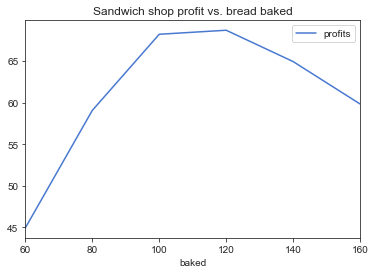

In [15]:
scenarios.plot(x='baked', y='profits')
pyplot.title('Sandwich shop profit vs. bread baked')

## Stochastic Nature of Simulation

There is still the issue of how much the results of this simulation vary from run to run. Running a simulation multiple times yields the the **posterior distribution** of the variables being simulated. In this case we are interested in the posterior distribution of the profitability vs. the number of breads baked.    

With a bit more code, the results of a number of number of simulation runs, the mean value, and the standard deviation of the profit across simulation runs can be computed and displayed. Run this code and examine the printed and plotted results. 

In [16]:
def sim_profit_replicas(n_replicas, bread_counts, n_days, lam, earned, cost, bread_probas):
    all_scenarios = []
    for replica_i in range(n_replicas):
        mean_profits = [sim_profit(n_bread, n_days, lam, earned, cost, bread_probas).profit.mean()
            for n_bread in bread_counts]
        scenarios = pandas.DataFrame({'baked': bread_counts, 'profits': mean_profits})
        scenarios['replica_i'] = replica_i
        all_scenarios.append(scenarios)
        
    return pandas.concat(all_scenarios)

replicas = sim_profit_replicas(
    n_replicas=100, 
    bread_counts=(60, 80, 100, 120, 140, 160), 
    n_days=100, 
    lam=100, 
    earned=1.00, 
    cost=.25, 
    bread_probas = bread_probas)

In [17]:
replicas.head()

,baked,profits,replica_i
0,60,44.96,0
1,80,59.00,0
2,100,68.30,0
3,120,68.96,0
4,140,63.95,0


We can easily compute the standard deviation of the mean daily profit across our simulation replicas like so

In [18]:
replicas.groupby('baked').profits.std()

baked
60     0.036886
80     0.177689
100    0.549144
120    0.869907
140    0.925164
160    0.991128
Name: profits, dtype: float64

And now we can plot each of the simulation replicas to get a sense of the profit variance for each amount of bread we might bake daily.

In [19]:
replicas.columns

Index(['baked', 'profits', 'replica_i'], dtype='object')

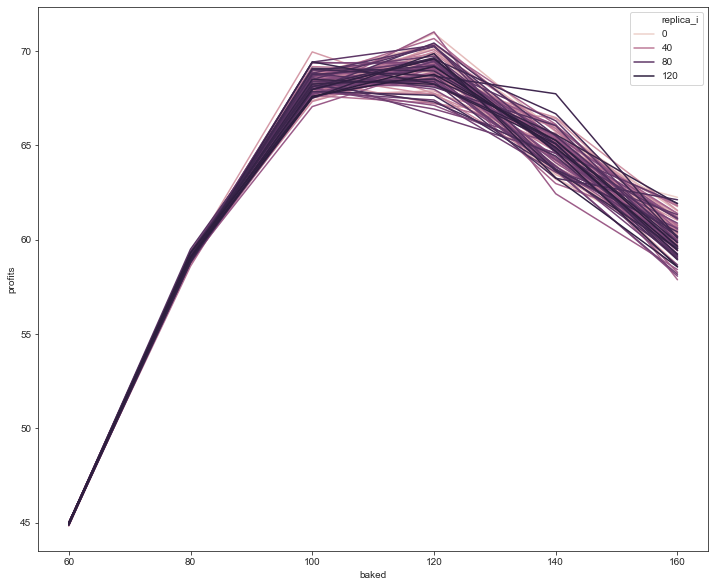

In [20]:
pyplot.figure(figsize=(12, 10))
seaborn.lineplot(x='baked', y='profits', hue='replica_i', data=replicas)

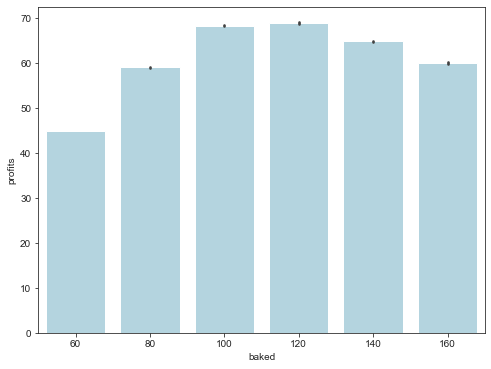

In [21]:
pyplot.figure(figsize=(8, 6))
seaborn.barplot(x='baked', y='profits', ci=95, data=replicas, color='LightBlue')

For most part the difference in profits between 100 and 120 loaves of bread prepared is minimal. This is particularly the case if you look at the standard deviation of these means. 

**Your turn:** In the cell below, create and exectue the code to simulate the profitabity of the sandwich show vs. bread baked for the case the bread costs 0.1, using 100 runs. How is the behavior of the result different from before.

#### Copyright 2019, 2020, Stephen F Elston. All rights reserved. 